<a href="https://colab.research.google.com/github/PratyushJha254/BTP/blob/main/TriangularIsingModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The image given below is from https://arxiv.org/html/2406.15724v2#S3 published on June 26, 2024. It mentions the critical temperature wrt R.
The code given below is the Python conversion of the code given in R in this repository (https://github.com/thomasgredig/MonteCarlo-Ising2D/blob/master/Ising2D-Triangular.R).

---

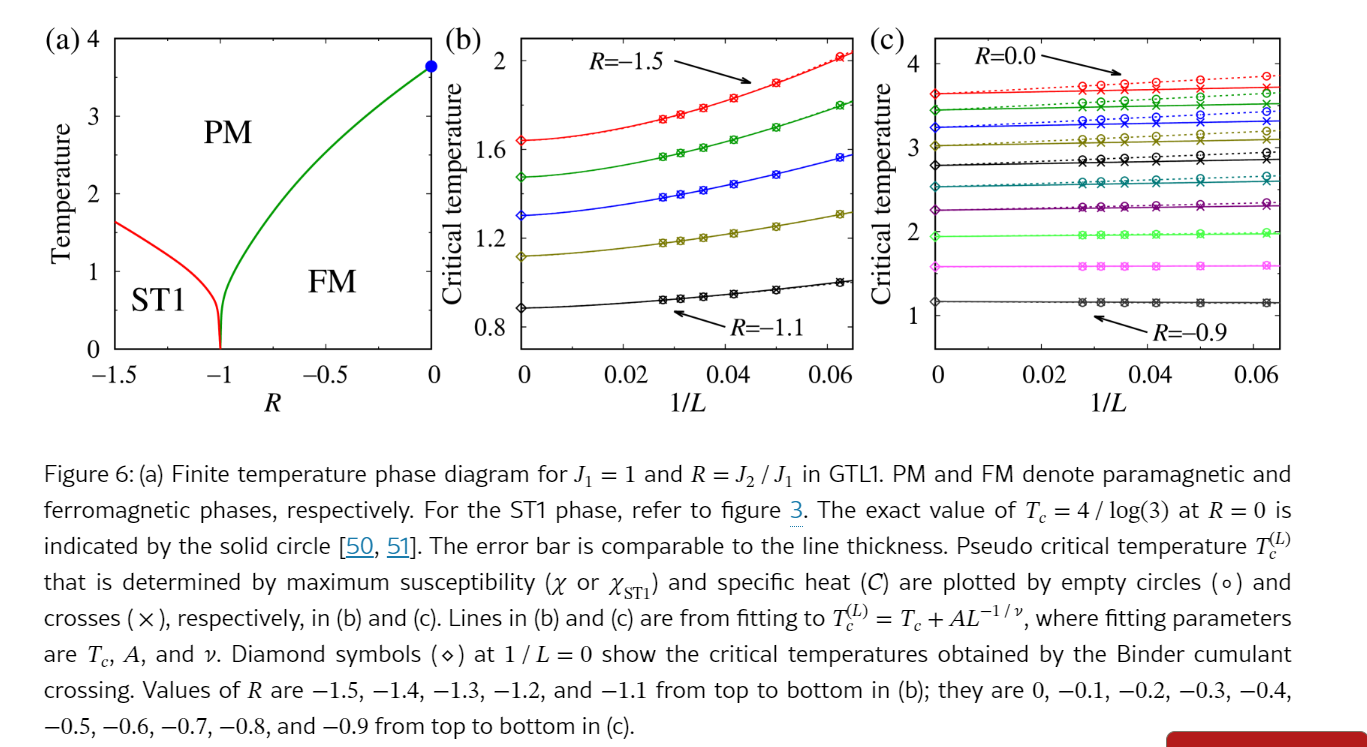

HERE
Temp: 3.0
Temp: 3.2
Temp: 3.4000000000000004
Temp: 3.6000000000000005
Temp: 3.800000000000001
Temp: 4.000000000000001
Temp: 4.200000000000001
Temp: 4.400000000000001
Temp: 4.600000000000001
Temp: 4.800000000000002
Temp: 5.000000000000002


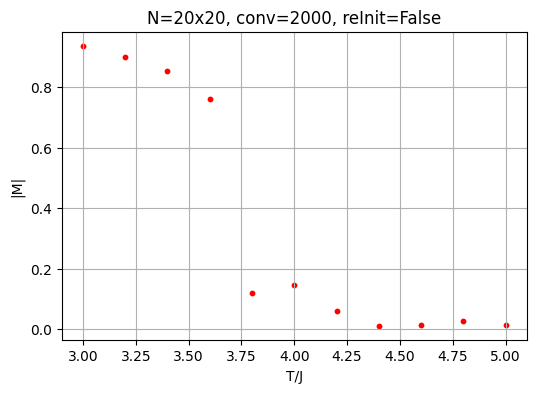

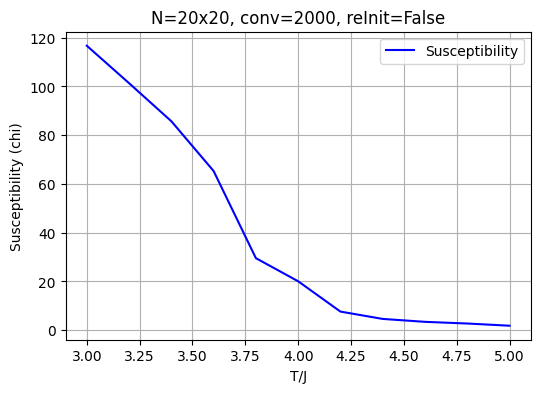

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import os

# Parameters
N = 20  # array size
J = 1   # interaction strength
conv_eq = 3  # convergence to equilibrium
conv = 2000  # measurements
reInit = False  # re-initialize for new temperature
TSeq = J * np.arange(3, 5.05, 0.2)  # temperature range

path_figs = 'images'
path_data = 'data'
os.makedirs(path_figs, exist_ok=True)
os.makedirs(path_data, exist_ok=True)
file_run_time = os.path.join(path_data, 'runTimes.csv')

if os.path.exists(file_run_time):
    d_run_time_all = pd.read_csv(file_run_time)
else:
    d_run_time_all = pd.DataFrame()

# Initialize spin array
spin = np.sign(np.random.rand(N, N) - 0.5)

# Function to calculate total energy
def total_energy(spin, N, J):
    energy = 0
    for i in range(N):
        for j in range(N):
            # Interaction with nearest neighbors (triangular lattice)
            energy -= J * spin[i, j] * (
                spin[(i + 1) % N, j] + spin[i, (j + 1) % N] + spin[(i - 1) % N, j] +
                spin[i, (j - 1) % N] + spin[(i + 1) % N, (j + 1) % N] + spin[(i - 1) % N, (j - 1) % N]
            )
    return energy / 2

# Metropolis algorithm for updating spins
def metropolis_update(spin, N, J, beta):
    for _ in range(N * N):
        i, j = np.random.randint(0, N, size=2)
        delta_e = 2 * J * spin[i, j] * (
            spin[(i + 1) % N, j] + spin[i, (j + 1) % N] +
            spin[(i - 1) % N, j] + spin[i, (j - 1) % N] +
            spin[(i + 1) % N, (j + 1) % N] + spin[(i - 1) % N, (j - 1) % N]
        )
        if delta_e < 0 or np.random.rand() < np.exp(-beta * delta_e):
            spin[i, j] *= -1

# Computation of M vs T
bSeq = 1 / TSeq
result = []
d_run_time = {
    'N': N,
    'J': J,
    'conv_eq': conv_eq,
    'conv': conv,
    'reInit': reInit,
    'date': time.strftime('%Y-%m-%d'),
    'start_time': time.time(),
    'end_time': 0,
    'diff_s': 0
}
print("HERE")
for b in bSeq:
    print(f"Temp: {1 / b}")
    if reInit:
        spin = np.sign(np.random.rand(N, N) - 0.5)

    # Equilibrate
    for _ in range(10):
        metropolis_update(spin, N, J, b)

    Mavg, M2avg = 0, 0
    for _ in range(conv):
        metropolis_update(spin, N, J, b)
        Ms = np.sum(spin)
        Mavg += Ms
        M2avg += Ms * Ms

    result.append({
        'b': b,
        'conv': conv,
        'Mavg': Mavg,
        'M2avg': M2avg,
        'T_J': 1 / (b * J),
        'chi': (M2avg / (conv * N * N) - (Mavg / (conv * N * N))**2) * b
    })

# Save timing data
d_run_time['end_time'] = time.time()
d_run_time['diff_s'] = d_run_time['end_time'] - d_run_time['start_time']
d_run_time['type'] = '2D Tri'
d_run_time['step'] = TSeq[1] - TSeq[0]
d_run_time['TempStart'] = TSeq[0]
d_run_time_all = pd.concat([d_run_time_all, pd.DataFrame([d_run_time])], ignore_index=True)
d_run_time_all.to_csv(file_run_time, index=False)

# Save results
df_result = pd.DataFrame(result)
result_file = os.path.join(path_data, f'Ising2D-Tri-{N}x{N}-c{conv}.csv')
df_result.to_csv(result_file, index=False)

# Plot results
plt.figure(figsize=(6, 4))
plt.scatter(df_result['T_J'], abs(df_result['Mavg']) / (conv * N * N), color='red', s=10)
plt.title(f'N={N}x{N}, conv={conv}, reInit={reInit}')
plt.xlabel('T/J')
plt.ylabel('|M|')
plt.grid(True)
plt.savefig(os.path.join(path_figs, f'Ising2D-Tri-{N}x{N}-c{conv}.png'), dpi=220)
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(df_result['T_J'], df_result['chi'], label='Susceptibility', color='blue')
plt.title(f'N={N}x{N}, conv={conv}, reInit={reInit}')
plt.xlabel('T/J')
plt.ylabel('Susceptibility (chi)')
plt.grid(True)
plt.legend()
plt.savefig(os.path.join(path_figs, f'Ising2D-Tri-{N}x{N}-c{conv}-Chi.png'), dpi=220)
plt.show()


After quickly reading through the paper, it seems that the order parameter for ST1 is provided, but I’m unsure if it’s explicitly mentioned for ST2 and ST3.

In [ ]:
def metropolis_update_NNN(spin, N, J, beta, R):
  # R = J_NNN/J_NN or J2/J1 as mentioned in https://arxiv.org/html/2406.15724v2#S3
    for _ in range(N * N):
        i, j = np.random.randint(0, N, size=2)
        delta_e = 2 * J * spin[i, j] * (
            # for NN
            spin[(i + 1) % N, j] + spin[i, (j + 1) % N] +
            spin[(i - 1) % N, j] + spin[i, (j - 1) % N] +
            spin[(i + 1) % N, (j + 1) % N] + spin[(i - 1) % N, (j - 1) % N]
            # for NNN
            + R * (
                spin[(i + 2) % N, (j + 1) % N] +
                spin[(i + 1) % N, (j - 1) % N] + spin[(i + 1) % N, (j + 2) % N] +
                spin[(i - 1) % N, (j - 2) % N] + spin[(i - 1) % N, (j + 1) % N] +
                spin[(i - 2) % N, (j - 1) % N]
            )
        )
        if delta_e < 0 or np.random.rand() < np.exp(-beta * delta_e):
            spin[i, j] *= -1

Temp: 3.0
Temp: 3.2
Temp: 3.4000000000000004
Temp: 3.6000000000000005
Temp: 3.800000000000001
Temp: 4.000000000000001
Temp: 4.200000000000001
Temp: 4.400000000000001


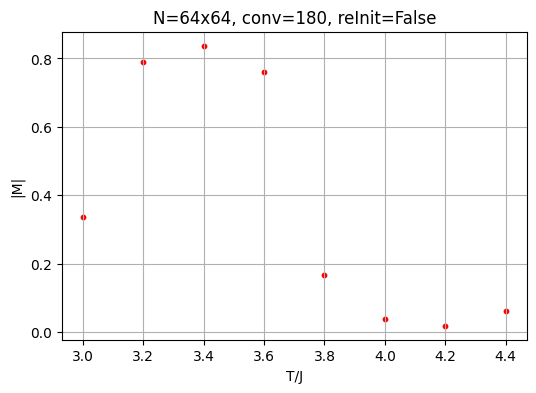

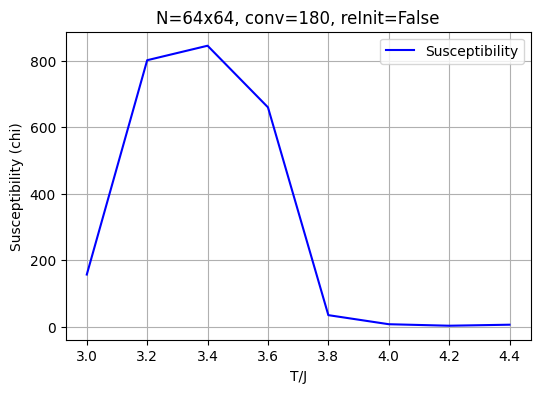

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import os

# Parameters
N = 64  # array size
J = 1   # interaction strength
conv_eq = 2  # convergence to equilibrium
conv = 180  # measurements
reInit = False  # re-initialize for new temperature
TSeq = J * np.arange(3, 4.45, 0.2)  # temperature range

path_figs = 'images'
path_data = 'data'
os.makedirs(path_figs, exist_ok=True)
os.makedirs(path_data, exist_ok=True)
file_run_time = os.path.join(path_data, 'runTimes.csv')

if os.path.exists(file_run_time):
    d_run_time_all = pd.read_csv(file_run_time)
else:
    d_run_time_all = pd.DataFrame()

# Initialize spin array
spin = np.sign(np.random.rand(N, N) - 0.5)

# Function to calculate total energy
def total_energy(spin, N, J):
    energy = 0
    for i in range(N):
        for j in range(N):
            # Interaction with nearest neighbors (triangular lattice)
            energy -= J * spin[i, j] * (
                spin[(i + 1) % N, j] + spin[i, (j + 1) % N] + spin[(i - 1) % N, j] +
                spin[i, (j - 1) % N] + spin[(i + 1) % N, (j + 1) % N] + spin[(i - 1) % N, (j - 1) % N]
            )
    return energy / 2

# Metropolis algorithm for updating spins
def metropolis_update(spin, N, J, beta):
    for _ in range(N * N):
        i, j = np.random.randint(0, N, size=2)
        delta_e = 2 * J * spin[i, j] * (
            spin[(i + 1) % N, j] + spin[i, (j + 1) % N] +
            spin[(i - 1) % N, j] + spin[i, (j - 1) % N] +
            spin[(i + 1) % N, (j + 1) % N] + spin[(i - 1) % N, (j - 1) % N]
        )
        if delta_e < 0 or np.random.rand() < np.exp(-beta * delta_e):
            spin[i, j] *= -1

# Computation of M vs T
bSeq = 1 / TSeq
result = []
d_run_time = {
    'N': N,
    'J': J,
    'conv_eq': conv_eq,
    'conv': conv,
    'reInit': reInit,
    'date': time.strftime('%Y-%m-%d'),
    'start_time': time.time(),
    'end_time': 0,
    'diff_s': 0
}

# Save Configuration and Temperature
X = []
y = []

for idx, b in enumerate(bSeq):
    print(f"Temp: {1 / b}")
    if reInit:
        spin = np.sign(np.random.rand(N, N) - 0.5)

    # Equilibrate
    for _ in range(conv_eq * 200):
        metropolis_update(spin, N, J, b)

    # Save lattice state at first temperature
    if idx == 0:
        plt.figure(figsize=(6, 6))
        plt.imshow(spin, cmap='gray', interpolation='nearest')
        plt.title(f'Lattice at T={1/b:.2f} (Initial)')
        plt.colorbar(label='Spin')
        plt.savefig(os.path.join(path_figs, f'Lattice_T{1/b:.2f}_Initial.png'), dpi=220)
        plt.close()

    Mavg, M2avg = 0, 0
    for _ in range(conv):
        metropolis_update(spin, N, J, b)
        Ms = np.sum(spin)
        Mavg += Ms
        M2avg += Ms * Ms

    result.append({
        'b': b,
        'conv': conv,
        'Mavg': Mavg,
        'M2avg': M2avg,
        'T_J': 1 / (b * J),
        'chi': (M2avg / (conv * N * N) - (Mavg / (conv * N * N))**2) * b
    })

    X.append(spin.copy())
    y.append( 1 / (b * J))

    # Save lattice and results for this temperature
    # np.savez(os.path.join(path_data, f'Lattice_T{1/b:.2f}.npz'), spin=spin, T=1/b)
np.savez('triangular_nn_64.npz', X=X, y=y)

# Save lattice state at last temperature
plt.figure(figsize=(6, 6))
plt.imshow(spin, cmap='gray', interpolation='nearest')
plt.title(f'Lattice at T={1/b:.2f} (Final)')
plt.colorbar(label='Spin')
plt.savefig(os.path.join(path_figs, f'Lattice_T{1/b:.2f}_Final.png'), dpi=220)
plt.close()

# Save timing data
d_run_time['end_time'] = time.time()
d_run_time['diff_s'] = d_run_time['end_time'] - d_run_time['start_time']
d_run_time['type'] = '2D Tri'
d_run_time['step'] = TSeq[1] - TSeq[0]
d_run_time['TempStart'] = TSeq[0]
d_run_time_all = pd.concat([d_run_time_all, pd.DataFrame([d_run_time])], ignore_index=True)
d_run_time_all.to_csv(file_run_time, index=False)

# Save results
df_result = pd.DataFrame(result)
result_file = os.path.join(path_data, f'Ising2D-Tri-{N}x{N}-c{conv}.csv')
df_result.to_csv(result_file, index=False)

# Plot results
plt.figure(figsize=(6, 4))
plt.scatter(df_result['T_J'], abs(df_result['Mavg']) / (conv * N * N), color='red', s=10)
plt.title(f'N={N}x{N}, conv={conv}, reInit={reInit}')
plt.xlabel('T/J')
plt.ylabel('|M|')
plt.grid(True)
plt.savefig(os.path.join(path_figs, f'Ising2D-Tri-{N}x{N}-c{conv}.png'), dpi=220)
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(df_result['T_J'], df_result['chi'], label='Susceptibility', color='blue')
plt.title(f'N={N}x{N}, conv={conv}, reInit={reInit}')
plt.xlabel('T/J')
plt.ylabel('Susceptibility (chi)')
plt.grid(True)
plt.legend()
plt.savefig(os.path.join(path_figs, f'Ising2D-Tri-{N}x{N}-c{conv}-Chi.png'), dpi=220)
plt.show()


25
[[-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]
 ...
 [-1  1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]]


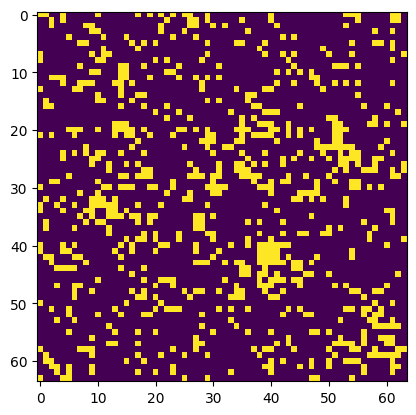

In [ ]:
from tensorflow import keras
from keras.utils import to_categorical
import numpy as np
from matplotlib import pyplot as plt

def full_file_loader(file_name = 'LRIM_FT_64L_data_6_11_maxepochs.npz', Tc = 2.27):
    data = np.load(file_name)
    X = None
    Y = None
    y = None
    print(len(data))
    print(data['lattice_T60'])
    plt.imshow(data['lattice_T84'])
    # X = data['X']
    # Y = data['y']
    # Tc = 9.75 # For a square lattice following Ising Model
    # y = Y > Tc
    # y = to_categorical(y.astype(int))
    return X, y, Y

X, y, Y = full_file_loader()

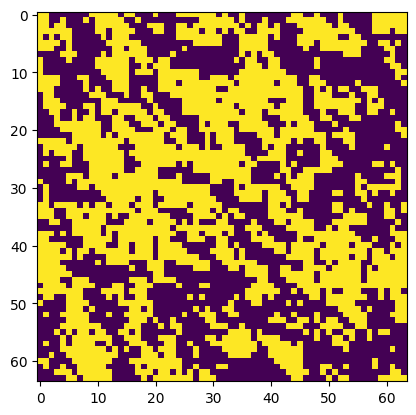

In [ ]:
plt.imshow(X[7])

Temp: 3.0
Temp: 3.2
Temp: 3.4000000000000004
Temp: 3.6000000000000005
Temp: 3.800000000000001
Temp: 4.000000000000001
Temp: 4.200000000000001
Temp: 4.400000000000001
Temp: 4.600000000000001
Temp: 4.800000000000002
Temp: 5.000000000000002


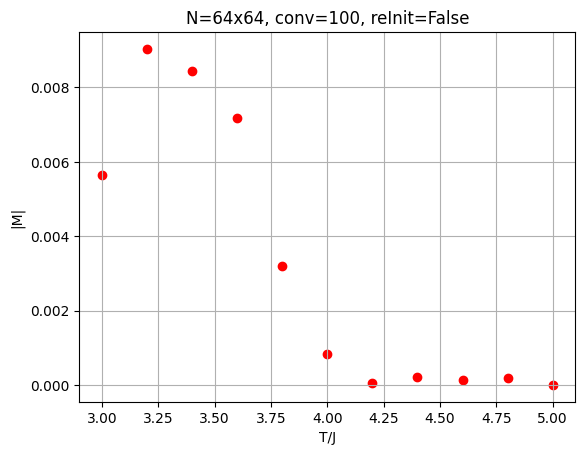

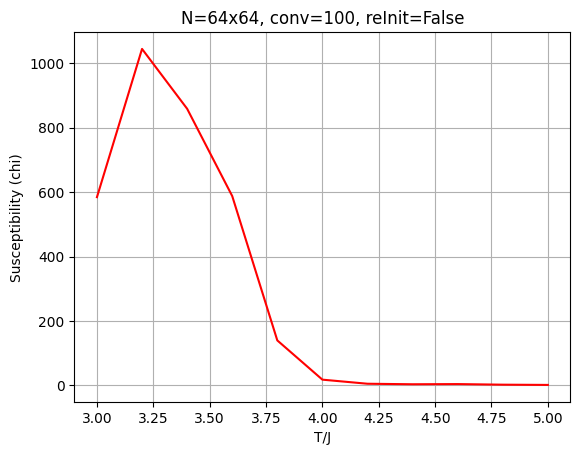

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import time

# Parameters
N = 64           # array size
J = 1            # interaction strength
conv_eq = 3000   # convergence to equilibrium
conv = 20      # measurements
reInit = False   # re-initialize for new temperature
TSeq = J * np.arange(3, 5.05, 0.2)  # temperature range

# Paths
path_FIGS = 'images'
path_DATA = 'data'
os.makedirs(path_FIGS, exist_ok=True)
os.makedirs(path_DATA, exist_ok=True)
file_runTime = os.path.join(path_DATA, 'runTimes.csv')

if os.path.exists(file_runTime):
    d_runTimeAll = pd.read_csv(file_runTime)
else:
    d_runTimeAll = pd.DataFrame()

# Array Initialization
def initialize_spin(N):
    return np.sign(np.random.rand(N, N) - 0.5)

def total_energy(spin, N, J):
    energy = 0
    for i in range(N):
        for j in range(N):
            energy -= J * spin[i, j] * (
                spin[(i + 1) % N, j] + spin[i, (j + 1) % N] +
                spin[(i - 1) % N, j] + spin[i, (j - 1) % N] +
                spin[(i + 1) % N, (j - 1) % N] + spin[(i - 1) % N, (j + 1) % N]
            )
    return energy / 2

def metropolis_step(spin, N, beta, J):
    for _ in range(400):
        i, j = np.random.randint(0, N, 2)
        delta_E = 2 * J * spin[i, j] * (
            spin[(i + 1) % N, j] + spin[i, (j + 1) % N] +
            spin[(i - 1) % N, j] + spin[i, (j - 1) % N] +
            spin[(i + 1) % N, (j - 1) % N] + spin[(i - 1) % N, (j + 1) % N]
        )
        if delta_E <= 0 or np.random.rand() < np.exp(-beta * delta_E):
            spin[i, j] *= -1

def compute_ising_2d_triangular(spin, steps, N, beta, J):
    for _ in range(100):
        metropolis_step(spin, N, beta, J)

# Save Configuration and Temperature
X = []
y = []

# Computation Intensive Part: M vs T
d_runTime = {
    'N': N, 'J': J, 'conv_eq': conv_eq, 'conv': conv, 'reInit': reInit,
    'date': time.strftime('%Y-%m-%d'), 'start_time': time.time(), 'end_time': 0, 'diff_s': 0
}

bSeq = 1 / TSeq
results = []
spin = initialize_spin(N)

for b in bSeq:
    T = 1 / b
    print(f"Temp: {T}")
    if reInit:
        spin = initialize_spin(N)

    compute_ising_2d_triangular(spin, conv_eq * N * N, N, b, J)

    Mavg = 0
    M2avg = 0
    for _ in range(conv):
        compute_ising_2d_triangular(spin, N * N, N, b, J)
        Ms = np.sum(spin)
        Mavg += Ms
        M2avg += Ms * Ms

    Mavg /= conv
    M2avg /= conv

    results.append({
        'b': b, 'conv': conv, 'Mavg': Mavg, 'M2avg': M2avg,
        'T_J': T / J,
        'chi': (M2avg / (N * N) - (Mavg / (N * N)) ** 2) * b
    })

    X.append(spin.copy())
    y.append(T)

# Save timing
d_runTime['end_time'] = time.time()
d_runTime['diff_s'] = d_runTime['end_time'] - d_runTime['start_time']
d_runTime['type'] = '2D Tri'
d_runTime['step'] = TSeq[1] - TSeq[0]
d_runTime['TempStart'] = TSeq[0]
d_runTimeAll = pd.concat([d_runTimeAll, pd.DataFrame([d_runTime])], ignore_index=True)
d_runTimeAll.to_csv(file_runTime, index=False)

# Save Lattice Configurations and Temperatures in NPZ Format
X = np.array(X)
y = np.array(y)
np.savez_compressed('lattice_data.npz', X=X, y=y)

# Graphing of Data
results_df = pd.DataFrame(results)

plt.figure()
plt.scatter(results_df['T_J'], np.abs(results_df['Mavg']) / (conv * N * N), color='red')
plt.title(f'N={N}x{N}, conv={conv}, reInit={reInit}')
plt.xlabel('T/J')
plt.ylabel('|M|')
plt.grid(True)
plt.savefig(os.path.join(path_FIGS, f'Ising2D-Tri-{N}x{N}-c{conv}.png'))

plt.figure()
plt.plot(results_df['T_J'], results_df['chi'], 'r-')
plt.title(f'N={N}x{N}, conv={conv}, reInit={reInit}')
plt.xlabel('T/J')
plt.ylabel('Susceptibility (chi)')
plt.grid(True)
plt.savefig(os.path.join(path_FIGS, f'Ising2D-Tri-{N}x{N}-c{conv}-Chi.png'))
